# 3 Model creation and training

In [1]:
# import all libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import sagemaker
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
from sagemaker.predictor import csv_serializer
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.inputs import TrainingInput
from sagemaker.pytorch import PyTorch, PyTorchModel

from utils import dataset_treatment, dataset_treatment_test

Now that we found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Loading

In [17]:
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';') # We load azdias only to facilitate the cleaning
mailout_data = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(mailout_data.RESPONSE.value_counts())

0    42430
1      532
Name: RESPONSE, dtype: int64


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='RESPONSE', ylabel='count'>

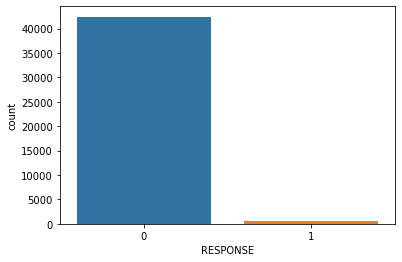

In [4]:
sns.countplot("RESPONSE", data=mailout_data)

As we can see the data is highly imbalanced. 98.7% (42430/(42430+532) X 100) of the training examples are labelled as "0" or "not responsive". This will need to be accounted for.  
First, let's clean our dataset and split the labels from the features.

### Splitting and cleaning

In [5]:
azidias1, mailout_data = dataset_treatment(azdias, mailout_data, cust=False)
azidias1 = None # Clear space

Deleting columns...
Deleting rows...
Encoding...


In [6]:
Y = pd.DataFrame(mailout_data["RESPONSE"])
del mailout_data["RESPONSE"]

In [7]:
mailout_data.shape

(33837, 354)

In [8]:
Y.shape

(33837, 1)

In [9]:
# Let's split our dataset into 80% training and 20% validation.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(mailout_data, Y, test_size=0.2)

### Save the data locally 
Now, let's save our train and validation data to csv files. Note that we make sure not to include header information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and validation data, it is assumed that the first entry in each row is the target variable.

In [10]:
data_dir = "data_model"

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Upload to S3 
Since we are currently running inside of a SageMaker session, we can use the object which represents this session to upload our data to the 'default' S3 bucket.

In [11]:
# Get the session and role
session = sagemaker.Session() 
role = get_execution_role()

In [12]:
prefix = 'capstone-Arvato'

val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

### Models design
Two different types of model will be investigated. We will use SageMaker's hyperparameter tuning functionality to investigate the possible XGBoost architectures and retain the one that performs the best on the validation set.

1) An XGBoost model  
XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework.
When it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now.  
The investigated hyperparameters will be: 

- The "max_depth" of the tree.
- The "eta" (learning rate equivalent).
- The "min_child_weight".
- The "subsample" ratio of training instances (to prevent overfitting).
- "gamma", the minimum loss reduction required to make a further partition on a leaf node of the tree.

2) A custom ANN model   
A simple, classic neural net composed of 4 fully connected layers.
This model won't be hyperparametrized.
  
### Metric
As stated earlier, the data is highly imbalanced. We have more thn 40 thousand - 0 responses and only 532 - 1 responses. Accuracy will be a bad metric to choose for this problem since the accuracy might always be more than 98% even if the model predicts all zeros.  

To address this imbalance while evaluating the model we need to chose a metric which will take this class imbalance into accounts. The usual metrics used for imbalanced classification are Precision and Recall or Area under Receiver Operating Curve (AUROC). The AUROC metric considers both true positive rate and false positive rate. It is a good choice for this problem, since we want to be able to correctly predict both cases i.e. whether a person becomes a customer or not

### 0) Benchmark
First, let's create a simple Logistic regression model on unscaled data to set a benchmark performance that we will aim to improve.

In [14]:
# Instantiate the model
lr = LogisticRegression()

In [15]:
# Train the model
lr.fit(X_train, Y_train)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [16]:
pred = lr.predict_proba(X_val)[:,1]

In [17]:
print("Baseline AUROC - ", roc_auc_score(Y_val, pred))

Baseline AUROC -  0.6848631867634674


Our baseline is therefore an AUROC of 68%

### 1) XGBoost model 

Now, let's explore if we can do better using and XGBoost model.  
The training/hyperparameter-tuning will be performed using the high level SageMaker API.  
To construct an estimator, the object which we wish to train, we need to provide the location of a container which contains the training code. Since XGBoost is a built in algorithm this container is provided by Amazon. To do so, we will be using the get_image_uri method.

In [18]:
# As stated above, we use this utility method to construct the image name for the training container.
container = sagemaker.image_uris.retrieve("xgboost", session.boto_region_name, "latest")

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    instance_count=1, # The number of instances to use for training
                                    instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix), # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

Before beginning the hyperparameter tuning, we should make sure to set any model specific hyperparameters that we wish to have default values.

In [19]:
xgb.set_hyperparameters(max_depth=7,
                        eta=0.39,
                        gamma=0.98,
                        min_child_weight=9,
                        subsample=0.892,
                        objective='binary:logistic', # 0/1 predictions
                        eval_metric='auc',
                        early_stopping_rounds=10,
                        num_round=300)

Now that we have our estimator object completely set up, it is time to create the hyperparameter tuner. To do this we need to construct a new object which contains each of the parameters we want SageMaker to tune.

In [20]:
xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:auc', # The metric used to compare trained models.
                                               objective_type = 'Maximize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 10, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(6, 10),
                                                    'eta'      : ContinuousParameter(0.2, 0.4),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.7, 1),
                                                    'gamma': ContinuousParameter(0, 1),
                                               })

In [16]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = TrainingInput(train_location, content_type='csv')
s3_input_validation = TrainingInput(val_location, content_type='csv')

In [22]:
# Let's train!
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

..............................................................................................................................................................................................................!


Once the hyperamater tuner has finished, we can retrieve information about the best performing model. Since we'd like to set up a batch transform job to test the best model, we can construct a new estimator object from the results of the best training job.

In [23]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())


2021-10-14 06:38:26 Starting - Preparing the instances for training
2021-10-14 06:38:26 Downloading - Downloading input data
2021-10-14 06:38:26 Training - Training image download completed. Training in progress.
2021-10-14 06:38:26 Uploading - Uploading generated training model
2021-10-14 06:38:26 Completed - Training job completed


Now that we have our best performing model, we can test it properly. Let's create predictions of our validation set and evaluate them with the roc_auc_score() function.  
To start with, we need to build a transformer object from our fit model.

In [24]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

We need to make sure to provide SageMaker with the type of data that we are providing to our model, in our case text/csv, so that it knows how to serialize our data. In addition, we need to make sure to let SageMaker know how to split our data up into chunks if the entire data set happens to be too large to send to our model all at once.   

In [17]:
# Get rid of the label part
X_val.to_csv(os.path.join(data_dir, 'validation-test.csv'), header=False, index=False)
valtest_location = session.upload_data(os.path.join(data_dir, 'validation-test.csv'), key_prefix=prefix)

In [ ]:
xgb_transformer.transform(valtest_location, content_type='text/csv', split_type='Line')

Now that the batch transform job has finished, the resulting output is stored on S3. Since we wish to analyze the output inside of our notebook we can use a bit of notebook magic to copy the output file from its S3 location and save it locally.

In [27]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-766337292225/xgboost-2021-10-14-06-48-37-300/validation-test.csv.out to data_model/validation-test.csv.out


In [28]:
pred = pd.read_csv(os.path.join(data_dir, 'validation-test.csv.out'), header=None)

In [29]:
print("XGBoost AUROC - ", roc_auc_score(Y_val, pred))

XGBoost AUROC -  0.8074147484042518


Without much suprise, our XGBoost model performed better than the benchmark model:  68% < 80%

### 2) Custom Pytorch ANN 

Finally, let's build and train a Pytorch ANN. 
The source code to build, train and predict is stored within the source_pytorch folder.  


In [18]:
# Instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='source_pytorch', 
                    role=role,
                    framework_version="1.0",
                    py_version="py3",
                    instance_count=1,
                    instance_type='ml.c4.xlarge',
                    output_path='s3://{}/{}'.format(session.default_bucket(), prefix),
                    sagemaker_session=session,
                    hyperparameters={
                        'input_dim': 354,  # num of features
                        'hidden_dim1': 512,
                        'hidden_dim2': 256,
                        'hidden_dim3': 64,
                        'output_dim': 1,
                        'epochs': 40 # could change to higher
                    })

In [19]:
# Train the estimator
estimator.fit({'train': s3_input_train})

2021-10-14 19:53:40 Starting - Starting the training job...
2021-10-14 19:54:03 Starting - Launching requested ML instancesProfilerReport-1634241220: InProgress
...
2021-10-14 19:54:40 Starting - Preparing the instances for training............
2021-10-14 19:56:41 Downloading - Downloading input data
2021-10-14 19:56:41 Training - Downloading the training image...
2021-10-14 19:57:04 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-10-14 19:57:00,319 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-10-14 19:57:00,322 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-10-14 19:57:00,335 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-10-14 19:57:01,001 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-10-14

In [20]:
# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     py_version="py3",
                     entry_point='predict.py',
                     source_dir='source_pytorch')

In [23]:
# Deploy the model to create a predictor
PyTorch_predictor = model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

---------------!

In [25]:
# Predict
Preds = np.squeeze(np.round(PyTorch_predictor.predict(X_val)))

In [27]:
print("PyTorch AUROC - ", roc_auc_score(Y_val, Preds))

PyTorch AUROC -  0.5059479947177575


As expected, whitout taking into account class imbalance the results are really poor.

In [ ]:
PyTorch_predictor.delete_endpoint()

### Kaggle competition
Now that we've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle.  
Obviously, we will choose the XGBoost model for the task.

In [13]:
mailout_test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
mailout_test_LNR = mailout_test["LNR"]

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
# Clean the data
_, mailout_test = dataset_treatment_test(azdias, mailout_test)

Deleting columns...
Deleting rows...
Encoding...


In [29]:
# Upload to S3
data_dir = "data_model"
prefix = 'capstone-Arvato'
mailout_test.to_csv(os.path.join(data_dir, 'kaggle.csv'), header=False, index=False)
test_location = session.upload_data(os.path.join(data_dir, 'kaggle.csv'), key_prefix=prefix)

In [30]:
# Recreate a xgb estimator from training job (I manually copy/pasted the best training job from the hyperparameter tuning job)
xgb = sagemaker.estimator.Estimator.attach("xgboost-211014-0630-006-a000fe15")


2021-10-14 06:38:26 Starting - Preparing the instances for training
2021-10-14 06:38:26 Downloading - Downloading input data
2021-10-14 06:38:26 Training - Training image download completed. Training in progress.
2021-10-14 06:38:26 Uploading - Uploading generated training model
2021-10-14 06:38:26 Completed - Training job completed


In [31]:
# Make a transformer
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [ ]:
# Make predictions
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [34]:
# Download the preds locally
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-766337292225/xgboost-2021-10-14-22-39-15-880/kaggle.csv.out to data_model/kaggle.csv.out


In [64]:
pred = pd.read_csv(os.path.join(data_dir, 'kaggle.csv.out'), header=None, names =["RESPONSE"] )

In [66]:
Result = pd.concat([mailout_test_LNR, pred], axis=1)

In [67]:
Result.head()

,LNR,RESPONSE
0,1754,0.069864
1,1770,0.037920
2,1465,0.019774
3,1470,0.019161
4,1478,0.020836


In [68]:
Result.to_csv("data_model/submission.csv", index=False)

The model scored "0.74"  
<img src="images/Untitled.png">

### Possible improvements:
1) In terms of data preparation  
    - I suspect that some columns had numerical categorical data (like 1 = mean something, 2 = mean something else) which should have been one-encoded  
    - There was a lot of missing values within rows. With a more in depth analyse of the meaning of the features, we could have imputed more plausible data (more plausible than just the most common).  
    - We could have added (crafted) another feature to the dataset: for each individual, its **cluster number** (from our PCA/K-mean processing). Ofc this feature should also be one-encoded.  
     
2 ) In terms of modelling  
I am quite annoyedfor the Pytorch model as I failed to:  
    - Implement a hyperparameter tuner (with SageMaker). It could have been interesting to test different combinations of (number of layers, number of neurons, batch-size, lr).  
    - Account for the class imbalance. My implementation of the many online examples all returned error messages I haven't been able to solve.  

    
    
    

    